In [2]:
%matplotlib inline

import pandas as pd
import seaborn as sns
sns.set_style("whitegrid")
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import scipy.stats as stats

# Load the data and group it by unique keys for visualization

In [3]:
df_put = pd.read_table("loops_13.putative_cdr.txt", sep="\t")
df_cdr = pd.read_table("loops_13.real_cdr.txt", sep="\t")

for key in set(df_put["pdb_id_kmer"]).intersection(df_cdr["pdb_id"]):
    df_put = df_put.loc[df_put["pdb_id_kmer"] != key,:]

In [4]:
df_put.head()

,pdb_id_kmer,chain_id_kmer,start_kmer,len_tcr,pos_tcr,aa_kmer,x_kmer,y_kmer,z_kmer,rmsd
0,12ca,A,72,13,0,A,0.000000,0.000000,0.000000,1.471901
1,12ca,A,72,13,1,V,2.435867,0.419666,2.914133,1.471901
2,12ca,A,72,13,2,L,3.901272,-1.472012,5.806936,1.471901
3,12ca,A,72,13,3,K,5.112862,0.373801,8.957265,1.471901
4,12ca,A,72,13,4,G,5.346375,-0.093429,12.738140,1.471901


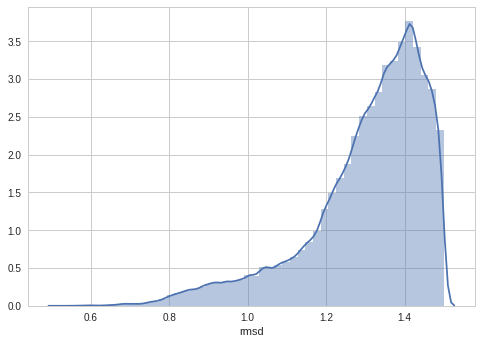

In [5]:
sns.distplot(df_put["rmsd"])

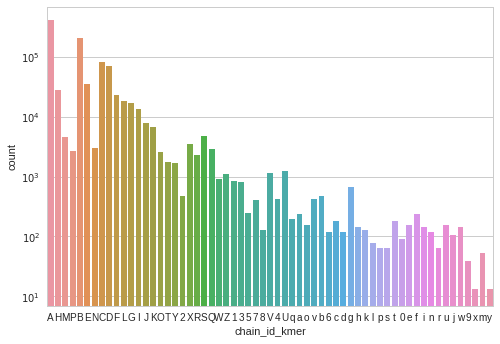

In [6]:
sns.countplot(df_put["chain_id_kmer"], log="y")

In [7]:
df_cdr.head()

,pdb_id,tcr_chain,len_tcr,pos_tcr,aa_tcr,x,y,z
0,2iam,TRA,13,0,C,0.000000,0.000000,0.000000
1,2iam,TRA,13,1,A,2.509573,1.112225,2.513987
2,2iam,TRA,13,2,A,3.364967,-0.345859,5.977036
3,2iam,TRA,13,3,L,5.778524,0.067249,8.943966
4,2iam,TRA,13,4,I,8.380416,-2.555646,9.870885


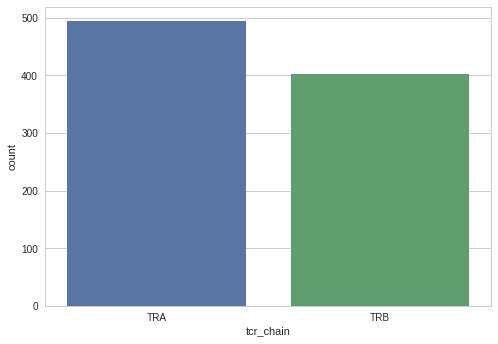

In [8]:
sns.countplot(df_cdr["tcr_chain"])

In [9]:
df = df_put.pivot_table("y_kmer", ["pdb_id_kmer", "chain_id_kmer", "start_kmer"], columns="pos_tcr")
df = df.reset_index()

df2 = df_put.pivot_table("aa_kmer", ["pdb_id_kmer", "chain_id_kmer", "start_kmer"], aggfunc=sum)
df2 = df2.reset_index()

df["sequence"] = df2["aa_kmer"]
df["key"] = df["pdb_id_kmer"] + "_" + df["chain_id_kmer"] + "_" + pd.Series(list(map(str, df["start_kmer"])))
df.drop(["pdb_id_kmer", "chain_id_kmer", "start_kmer"], axis=1, inplace=True)
df = df[["key", "sequence", 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]]
df_put_coord = df
df_put_coord.to_csv("put_coord_y.csv.gz", compression="gzip")
df_put_coord.head()

pos_tcr,key,sequence,0,1,2,3,4,5,6,7,8,9,10,11,12
0,12ca_A_72,AVLKGGPLDGTYR,0.0,0.419666,-1.472012,0.373801,-0.093429,-3.390903,-3.868015,-1.489832,2.019628,4.121258,3.189113,0.190724,-8.645559e-17
1,12e8_H_47,IGWIDPEIGDTEY,0.0,-1.337045,-1.477930,0.200611,-1.435675,1.350644,-0.116351,0.536057,2.774858,0.290151,0.613460,-1.398779,2.147809e-16
2,12e8_M_193,CEATHKTSTSPIV,0.0,1.201658,-0.508405,1.090160,-1.322735,-1.249319,-3.826830,-1.011135,2.774686,2.546791,1.639714,-1.334586,-1.766427e-16
3,12e8_P_47,IGWIDPEIGDTEY,0.0,-1.358886,-1.463286,0.265639,-1.376918,1.418180,-0.096963,0.341046,2.735928,0.303334,0.621209,-1.389282,1.172152e-15
4,132l_A_48,GSTDYGILQINSR,0.0,-0.118900,-0.694450,0.637058,-2.065290,-2.187927,0.051855,2.304336,2.035404,0.852265,1.104377,-1.918726,-4.860038e-16


In [10]:
df = df_cdr.pivot_table("z", ["pdb_id", "tcr_chain"], columns="pos_tcr")
df = df.reset_index()

df2 = df_cdr.pivot_table("aa_tcr", ["pdb_id", "tcr_chain"], aggfunc=sum)
df2 = df2.reset_index()

df["sequence"] = df2["aa_tcr"]
df["key"] = df["pdb_id"] + "_" + df["tcr_chain"]
df.drop(["pdb_id", "tcr_chain"], axis=1, inplace=True)
df = df[["key", "sequence", 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]]
df_cdr_coord = df
df_cdr_coord.to_csv("real_coord_z.csv.gz", compression="gzip")
df_cdr_coord.head()

pos_tcr,key,sequence,0,1,2,3,4,5,6,7,8,9,10,11,12
0,1ao7_TRA,CAVTTDSWGKLQF,0.0,2.972840,6.067100,9.204860,12.448935,14.931039,15.295369,14.285620,11.665090,7.954148,5.975136,3.027227,3.551127e-17
1,1d9k_TRB,CASGGQGRAEQFF,0.0,2.616682,5.718702,8.709894,12.377870,14.405574,15.855594,13.414792,11.413157,8.515110,6.079673,3.141242,0.000000e+00
2,1kj2_TRA,CAARYQGGRALIF,0.0,2.688346,5.961303,8.934960,12.301876,15.711093,16.125363,12.460972,10.557976,7.129182,5.565804,3.147036,-9.377599e-16
3,1mi5_TRB,CASSLGQAYEQYF,0.0,2.867816,5.779146,8.812434,12.099542,14.036292,13.355177,13.901733,12.161696,8.586916,5.969588,3.013926,-4.711447e-16
4,1oga_TRB,CASSSRSSYEQYF,0.0,2.650239,5.832221,8.952908,11.605589,14.214886,13.472754,13.303158,12.359548,8.934154,6.109995,3.109851,-4.371103e-17


In [11]:
df_put_x = pd.melt(df_put, ["pdb_id_kmer", "chain_id_kmer", "start_kmer", "pos_tcr"], "x_kmer")
df_put_y = pd.melt(df_put, ["pdb_id_kmer", "chain_id_kmer", "start_kmer", "pos_tcr"], "y_kmer")
df_put_z = pd.melt(df_put, ["pdb_id_kmer", "chain_id_kmer", "start_kmer", "pos_tcr"], "z_kmer")

df_cdr_x = pd.melt(df_cdr, ["pdb_id", "tcr_chain", "pos_tcr"], "x")
df_cdr_y = pd.melt(df_cdr, ["pdb_id", "tcr_chain", "pos_tcr"], "y")
df_cdr_z = pd.melt(df_cdr, ["pdb_id", "tcr_chain", "pos_tcr"], "z")

# Visualization

74528
69


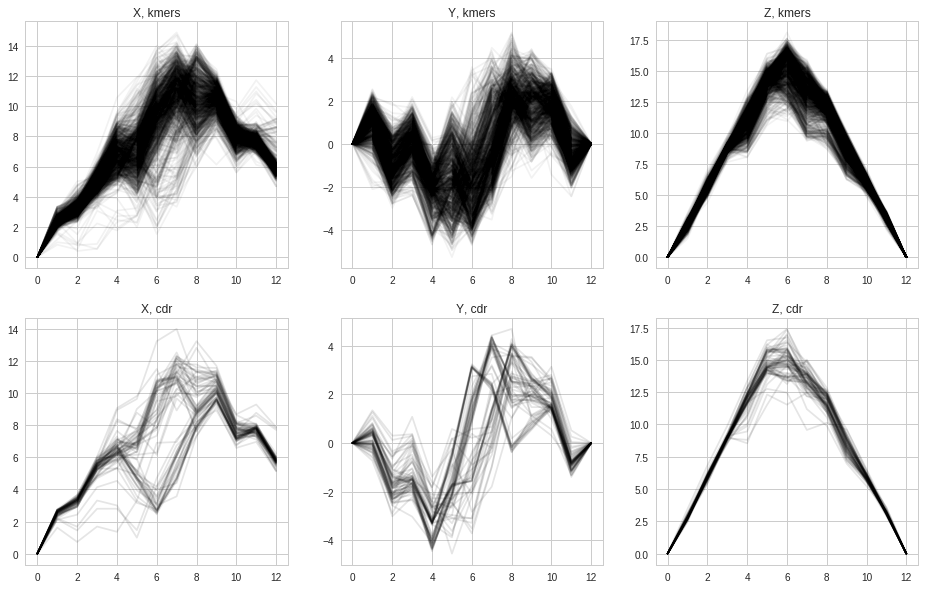

In [12]:
fig, ax = plt.subplots(2,3,figsize=(16,10))
ax[0,0].set_title("X, kmers")
ax[0,1].set_title("Y, kmers")
ax[0,2].set_title("Z, kmers")
ax[1,0].set_title("X, cdr")
ax[1,1].set_title("Y, cdr")
ax[1,2].set_title("Z, cdr")

df_tmp = df_put_x.groupby(["pdb_id_kmer", "chain_id_kmer", "start_kmer"])
print(len(df_tmp.groups.keys()))
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[0,0].plot(range(13), df_tmp.get_group(gr)["value"], c="black", alpha=.05)
    if i > 1000:
        break
        
df_tmp = df_put_y.groupby(["pdb_id_kmer", "chain_id_kmer", "start_kmer"])
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[0,1].plot(range(13), df_tmp.get_group(gr)["value"], c="black", alpha=.05)
    if i > 1000:
        break
        
df_tmp = df_put_z.groupby(["pdb_id_kmer", "chain_id_kmer", "start_kmer"])
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[0,2].plot(range(13), df_tmp.get_group(gr)["value"], c="black", alpha=.05)
    if i > 1000:
        break
        
df_tmp = df_cdr_x.groupby(["pdb_id", "tcr_chain"])
print(len(df_tmp.groups.keys()))
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[1,0].plot(range(13), df_tmp.get_group(gr)["value"], c="black", alpha=.1)
        
df_tmp = df_cdr_y.groupby(["pdb_id", "tcr_chain"])
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[1,1].plot(range(13), df_tmp.get_group(gr)["value"], c="black", alpha=.1)
        
df_tmp = df_cdr_z.groupby(["pdb_id", "tcr_chain"])
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[1,2].plot(range(13), df_tmp.get_group(gr)["value"], c="black", alpha=.1)

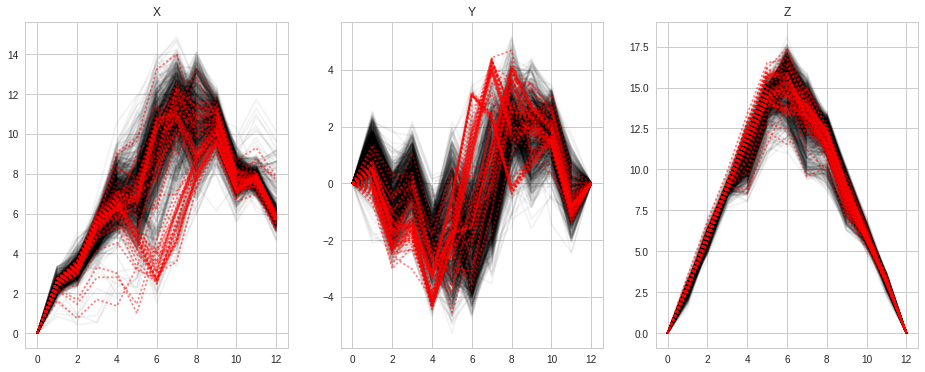

In [13]:
fig, ax = plt.subplots(1,3,figsize=(16,6))
ax[0].set_title("X")
ax[1].set_title("Y")
ax[2].set_title("Z")

df_tmp = df_put_x.groupby(["pdb_id_kmer", "chain_id_kmer", "start_kmer"])
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[0].plot(range(13), df_tmp.get_group(gr)["value"], c="black", alpha=.05)
    if i > 1000:
        break
        
df_tmp = df_put_y.groupby(["pdb_id_kmer", "chain_id_kmer", "start_kmer"])
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[1].plot(range(13), df_tmp.get_group(gr)["value"], c="black", alpha=.05)
    if i > 1000:
        break
        
df_tmp = df_put_z.groupby(["pdb_id_kmer", "chain_id_kmer", "start_kmer"])
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[2].plot(range(13), df_tmp.get_group(gr)["value"], c="black", alpha=.05)
    if i > 1000:
        break
        
df_tmp = df_cdr_x.groupby(["pdb_id", "tcr_chain"])
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[0].plot(range(13), df_tmp.get_group(gr)["value"], linestyle="dotted", c="red", alpha=.5)
        
df_tmp = df_cdr_y.groupby(["pdb_id", "tcr_chain"])
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[1].plot(range(13), df_tmp.get_group(gr)["value"], linestyle="dotted", c="red", alpha=.5)
        
df_tmp = df_cdr_z.groupby(["pdb_id", "tcr_chain"])
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[2].plot(range(13), df_tmp.get_group(gr)["value"], linestyle="dotted", c="red", alpha=.5)

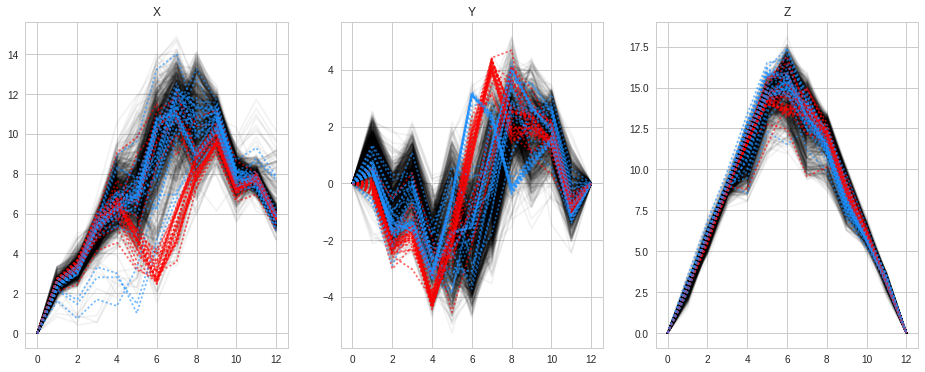

In [14]:
fig, ax = plt.subplots(1,3,figsize=(16,6))
ax[0].set_title("X")
ax[1].set_title("Y")
ax[2].set_title("Z")

df_tmp = df_put_x.groupby(["pdb_id_kmer", "chain_id_kmer", "start_kmer"])
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[0].plot(range(13), df_tmp.get_group(gr)["value"], c="black", alpha=.05)
    if i > 1000:
        break
        
df_tmp = df_put_y.groupby(["pdb_id_kmer", "chain_id_kmer", "start_kmer"])
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[1].plot(range(13), df_tmp.get_group(gr)["value"], c="black", alpha=.05)
    if i > 1000:
        break
        
df_tmp = df_put_z.groupby(["pdb_id_kmer", "chain_id_kmer", "start_kmer"])
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[2].plot(range(13), df_tmp.get_group(gr)["value"], c="black", alpha=.05)
    if i > 1000:
        break
        
df_tmp = df_cdr_x.groupby(["pdb_id", "tcr_chain"])
for i, gr in enumerate(df_tmp.groups.keys()):
    col = "dodgerblue" if gr[1] == "TRA" else "red"
    ax[0].plot(range(13), df_tmp.get_group(gr)["value"], linestyle="dotted", c=col, alpha=.6)
        
df_tmp = df_cdr_y.groupby(["pdb_id", "tcr_chain"])
for i, gr in enumerate(df_tmp.groups.keys()):
    col = "dodgerblue" if gr[1] == "TRA" else "red"
    ax[1].plot(range(13), df_tmp.get_group(gr)["value"], linestyle="dotted", c=col, alpha=.6)
        
df_tmp = df_cdr_z.groupby(["pdb_id", "tcr_chain"])
for i, gr in enumerate(df_tmp.groups.keys()):
    col = "dodgerblue" if gr[1] == "TRA" else "red"
    ax[2].plot(range(13), df_tmp.get_group(gr)["value"], linestyle="dotted", c=col, alpha=.6)

## Summary
There is a clear distinction between TRA and TRB groups by the X-coordinate, with some anomalous CDRs.

TRB lines by the X-coordinate have very little neighbouring peptides in contrast to the TRA CDR chain sequences.

Real CDRs tend to have less deviation from the starting point and at the final point by the Y-coordinate.

Shape of lines for the Y-coordinate are pretty close for TRA and TRB.

# Distribution of coordinates per position

## X coordinate

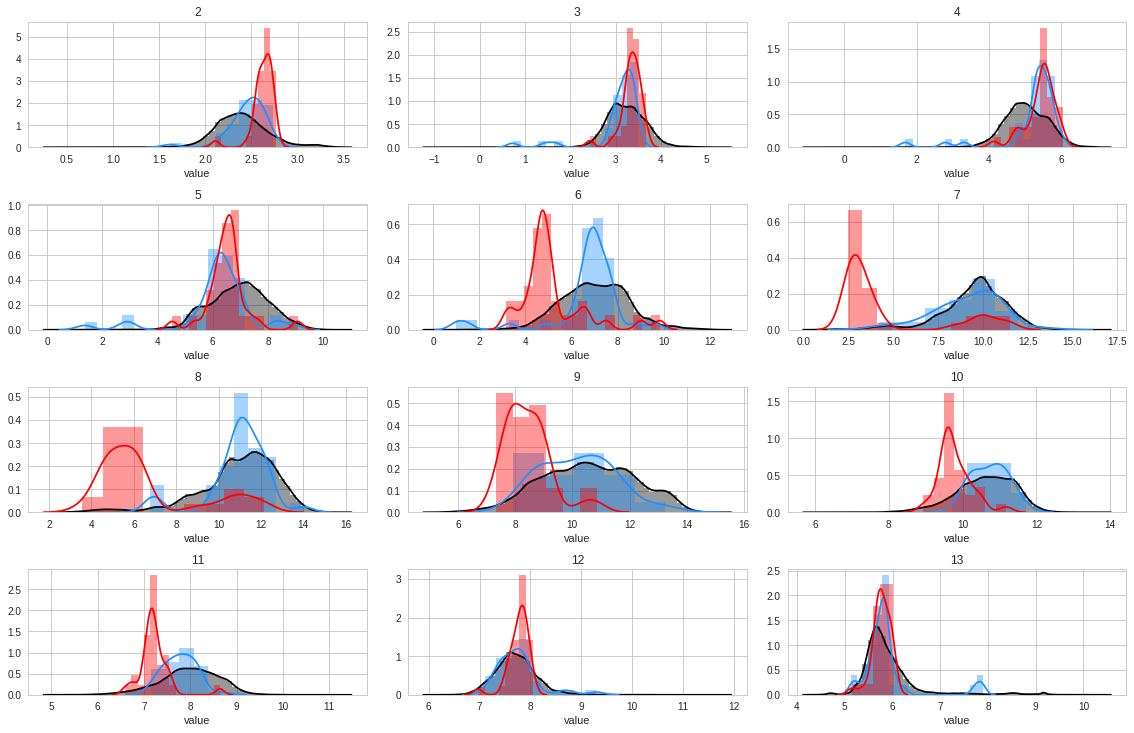

In [32]:
fig, ax = plt.subplots(4,3,figsize=(16,10))

plt.tight_layout(h_pad=3)

for j in range(1,13):
    r,c = (j-1) // 3, (j-1) % 3
    sns.distplot(df_put_x.loc[df_put_x["pos_tcr"] == j, "value"], ax=ax[r,c], color="black")
    sns.distplot(df_cdr_x.loc[(df_cdr_x["pos_tcr"] == j) & (df_cdr_x["tcr_chain"] == "TRA"), "value"], ax=ax[r,c], color="dodgerblue")
    sns.distplot(df_cdr_x.loc[(df_cdr_x["pos_tcr"] == j) & (df_cdr_x["tcr_chain"] == "TRB"), "value"], ax=ax[r,c], color="red")
    ax[r,c].set_title(j+1)

## Y coordinate

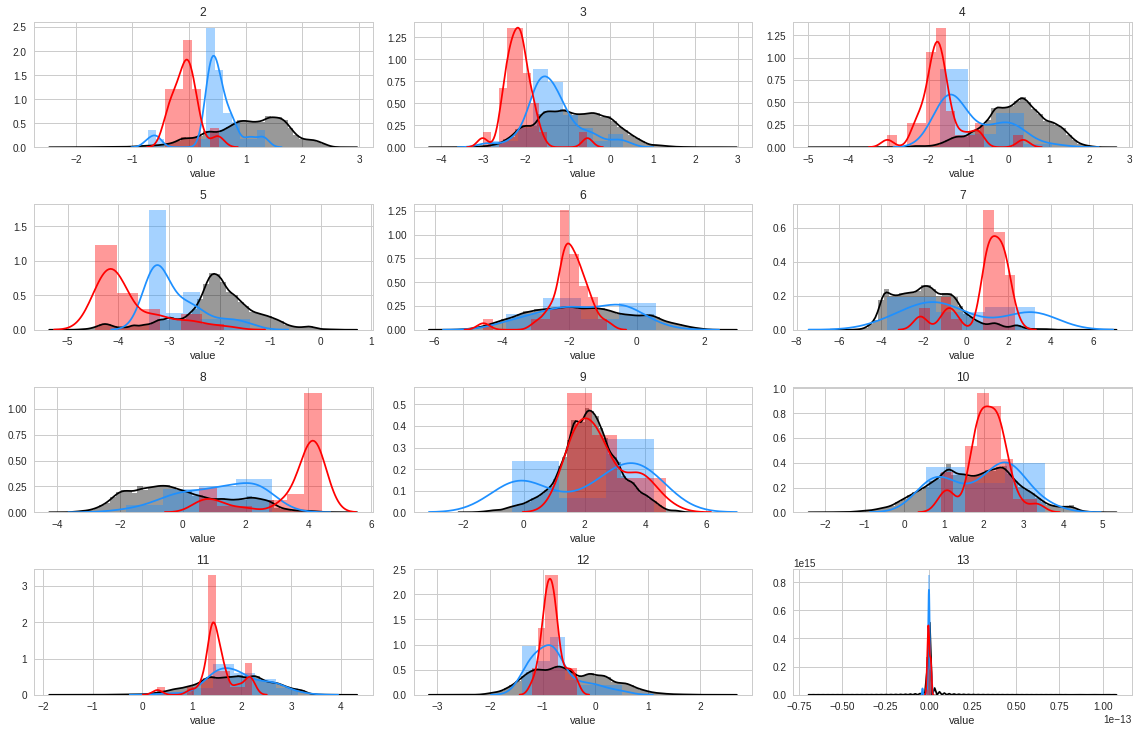

In [33]:
fig, ax = plt.subplots(4,3,figsize=(16,10))

plt.tight_layout(h_pad=3)

for j in range(1,13):
    r,c = (j-1) // 3, (j-1) % 3
    sns.distplot(df_put_y.loc[df_put_y["pos_tcr"] == j, "value"], ax=ax[r,c], color="black")
    sns.distplot(df_cdr_y.loc[(df_cdr_y["pos_tcr"] == j) & (df_cdr_y["tcr_chain"] == "TRA"), "value"], ax=ax[r,c], color="dodgerblue")
    sns.distplot(df_cdr_y.loc[(df_cdr_y["pos_tcr"] == j) & (df_cdr_y["tcr_chain"] == "TRB"), "value"], ax=ax[r,c], color="red")
    ax[r,c].set_title(j+1)

## Z coordinate

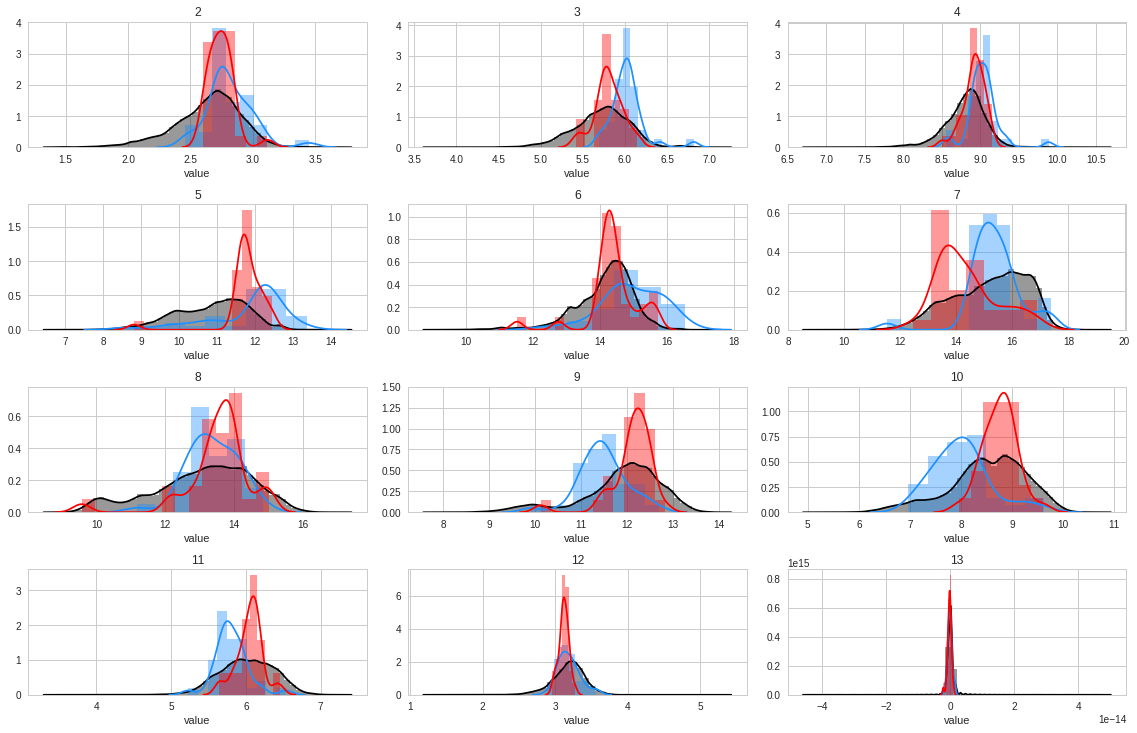

In [34]:
fig, ax = plt.subplots(4,3,figsize=(16,10))

plt.tight_layout(h_pad=3)

for j in range(1,13):
    r,c = (j-1) // 3, (j-1) % 3
    sns.distplot(df_put_z.loc[df_put_z["pos_tcr"] == j, "value"], ax=ax[r,c], color="black")
    sns.distplot(df_cdr_z.loc[(df_cdr_z["pos_tcr"] == j) & (df_cdr_z["tcr_chain"] == "TRA"), "value"], ax=ax[r,c], color="dodgerblue")
    sns.distplot(df_cdr_z.loc[(df_cdr_z["pos_tcr"] == j) & (df_cdr_z["tcr_chain"] == "TRB"), "value"], ax=ax[r,c], color="red")
    ax[r,c].set_title(j+1)

## Summary

Distributions of coordinates for almost all positions for X and Z coodinates are close to Gauss.

Distributions of X coordinates for putative, TRA and TRB CDRs are quite close for the first 6 positions, and 12/13 positions.

TRA and putative distributions at the X coordinate are very close for all positions.

TRB is much lower than TRA/putative for the X coordinate at positions 6,7,8,9,10,11.

Distributions of Y coordinates for real CDRs are lower than for the putative ones in the first 5 positions. For 7 and 8 positions real CDRs are higher than the putative ones. This effect is more stronger for TRB than for TRA. (Probably due to Gly).

Distributions of Z coordinates are very similar to each other for all peptides.

# "Upside" / "downside" peptides analysis

In [18]:
df1 = df_cdr_x.loc[(df_cdr_x["pos_tcr"] == 2) & (df_cdr_x["value"] < 2) & (df_cdr_x["tcr_chain"] == "TRA"), :]
df2 = df_cdr_y.loc[(df_cdr_y["pos_tcr"] == 2) & (df_cdr_y["value"] < 0) & (df_cdr_y["tcr_chain"] == "TRA"), :]

df3 = df_cdr_x.loc[(df_cdr_x["pos_tcr"] == 6) & (df_cdr_x["value"] > 5) & (df_cdr_x["tcr_chain"] == "TRB"), :]
df4 = df_cdr_x.loc[(df_cdr_y["pos_tcr"] == 7) & (df_cdr_y["value"] < 3) & (df_cdr_y["tcr_chain"] == "TRB"), :]

print(df1.shape)
print(df2.shape)
print(df3.shape)
print(df4.shape)
print(set(df1.pdb_id).intersection(set(df2.pdb_id)))
print(df_cdr.loc[np.array(list(map(lambda x: x in set(df3.pdb_id).intersection(set(df4.pdb_id)), 
                                   df_cdr_x["pdb_id"]))), :])

(3, 5)
(36, 5)
(7, 5)
(6, 5)
set(['3pqy', '4ozh', '4z7v'])
    pdb_id tcr_chain  len_tcr  pos_tcr aa_tcr          x             y  \
26    2xn9       TRB       13        0      C   0.000000  0.000000e+00   
27    2xn9       TRB       13        1      A   2.567794 -3.896791e-02   
28    2xn9       TRB       13        2      S   3.389395 -1.884475e+00   
29    2xn9       TRB       13        3      S   5.610297 -1.201712e+00   
30    2xn9       TRB       13        4      S   6.733054 -2.643364e+00   
31    2xn9       TRB       13        5      R   7.489732 -8.772550e-01   
32    2xn9       TRB       13        6      S  11.144908 -2.084176e+00   
33    2xn9       TRB       13        7      S  11.802531  5.570819e-01   
34    2xn9       TRB       13        8      Y  10.405556  3.900837e+00   
35    2xn9       TRB       13        9      E  10.470674  2.580314e+00   
36    2xn9       TRB       13       10      Q   7.355026  2.215561e+00   
37    2xn9       TRB       13       11      Y   7.900

In [19]:
df1 = df_put_x.loc[(df_put_x["pos_tcr"] == 2) & (df_put_x["value"] < 2), :]
df2 = df_put_y.loc[(df_put_y["pos_tcr"] == 2) & (df_put_y["value"] < 0), :]

df3 = df_put_x.loc[(df_put_x["pos_tcr"] == 6) & (df_put_x["value"] > 5), :]
df4 = df_put_x.loc[(df_put_y["pos_tcr"] == 7) & (df_put_y["value"] < 3), :]

print(df1.shape)
print(df2.shape)
print(df3.shape)
print(df4.shape)

(276, 6)
(62376, 6)
(71766, 6)
(72423, 6)


In [20]:
df_cdr_x.loc[(df_cdr_x["pos_tcr"] == 6) & (df_cdr_x["value"] < 6) & (df_cdr_x["tcr_chain"] == "TRA"), :]

,pdb_id,tcr_chain,pos_tcr,variable,value
864,3pqy,TRA,6,x,4.706501
890,4z7v,TRA,6,x,4.205619


In [21]:
df_cdr_x.loc[(df_cdr_x["pos_tcr"] == 4) & (df_cdr_x["value"] < 4) & (df_cdr_x["tcr_chain"] == "TRA"), :]

,pdb_id,tcr_chain,pos_tcr,variable,value
524,4ozh,TRA,4,x,1.357835
862,3pqy,TRA,4,x,2.798550
888,4z7v,TRA,4,x,3.000207


In [22]:
df_cdr_x.loc[(df_cdr_x["pos_tcr"] == 6) & (df_cdr_x["value"] > 6) & (df_cdr_x["tcr_chain"] == "TRB"), :]

,pdb_id,tcr_chain,pos_tcr,variable,value
32,2xn9,TRB,6,x,11.144908
71,3vxr,TRB,6,x,9.548838
97,3vxs,TRB,6,x,9.711765
136,4y1a,TRB,6,x,10.337111
279,4y19,TRB,6,x,8.448482
331,3o4l,TRB,6,x,11.509035
877,1d9k,TRB,6,x,10.139364


# Correlations among coordinates

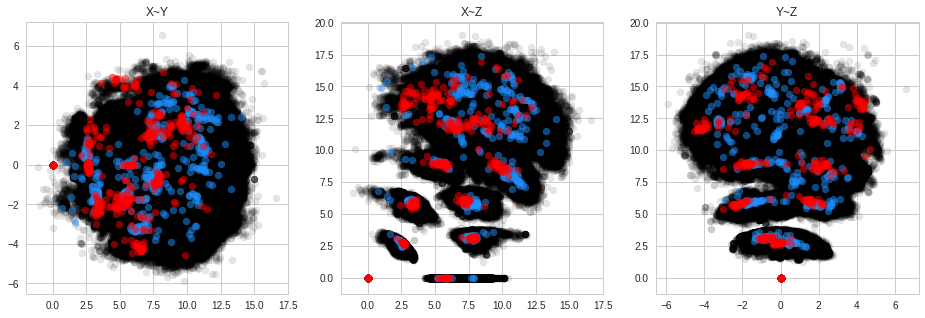

In [23]:
fig, ax = plt.subplots(1,3,figsize=(16,5))

ax[0].scatter(df_put_x["value"], df_put_y["value"], color="black", alpha=.1)
ax[0].scatter(df_cdr_x.loc[(df_cdr_x["tcr_chain"] == "TRA"), "value"], df_cdr_y.loc[(df_cdr_y["tcr_chain"] == "TRA"), "value"], color="dodgerblue", alpha=.5)
ax[0].scatter(df_cdr_x.loc[(df_cdr_x["tcr_chain"] == "TRB"), "value"], df_cdr_y.loc[(df_cdr_y["tcr_chain"] == "TRB"), "value"], color="red", alpha=.5)
ax[0].set_title("X~Y")

ax[1].scatter(df_put_x["value"], df_put_z["value"], color="black", alpha=.1)
ax[1].scatter(df_cdr_x.loc[(df_cdr_x["tcr_chain"] == "TRA"), "value"], df_cdr_z.loc[(df_cdr_z["tcr_chain"] == "TRA"), "value"], color="dodgerblue", alpha=.5)
ax[1].scatter(df_cdr_x.loc[(df_cdr_x["tcr_chain"] == "TRB"), "value"], df_cdr_z.loc[(df_cdr_z["tcr_chain"] == "TRB"), "value"], color="red", alpha=.5)
ax[1].set_title("X~Z")

ax[2].scatter(df_put_y["value"], df_put_z["value"], color="black", alpha=.1)
ax[2].scatter(df_cdr_y.loc[(df_cdr_y["tcr_chain"] == "TRA"), "value"], df_cdr_z.loc[(df_cdr_z["tcr_chain"] == "TRA"), "value"], color="dodgerblue", alpha=.5)
ax[2].scatter(df_cdr_y.loc[(df_cdr_y["tcr_chain"] == "TRB"), "value"], df_cdr_z.loc[(df_cdr_z["tcr_chain"] == "TRB"), "value"], color="red", alpha=.5)

ax[2].set_title("Y~Z")

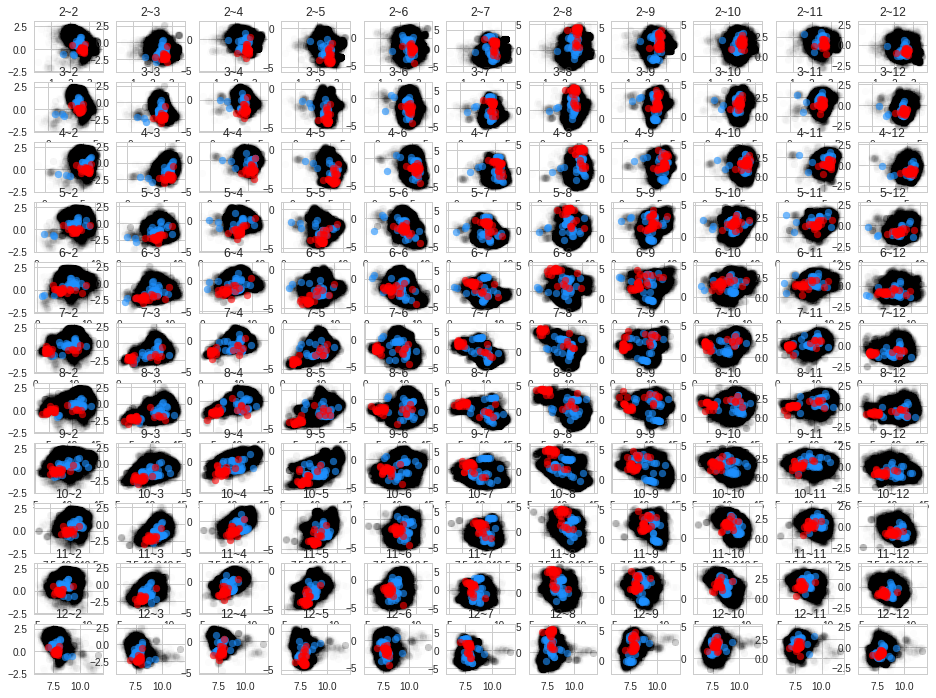

In [27]:
def plot_corr(df_put_l, df_put_r, df_cdr_l, df_cdr_r, pos_i, pos_j, ax):
    ax.scatter(df_put_l.loc[df_put_l["pos_tcr"] == pos_i, "value"], 
               df_put_r.loc[df_put_r["pos_tcr"] == pos_j, "value"], 
               color="black", alpha=.01)
    ax.scatter(df_cdr_l.loc[(df_cdr_l["pos_tcr"] == pos_i) & (df_cdr_l["tcr_chain"] == "TRA"), "value"], 
               df_cdr_r.loc[(df_cdr_r["pos_tcr"] == pos_j) & (df_cdr_r["tcr_chain"] == "TRA"), "value"], 
               color="dodgerblue", alpha=.6)
    ax.scatter(df_cdr_l.loc[(df_cdr_l["pos_tcr"] == pos_i) & (df_cdr_l["tcr_chain"] == "TRB"), "value"], 
               df_cdr_r.loc[(df_cdr_r["pos_tcr"] == pos_j) & (df_cdr_r["tcr_chain"] == "TRB"), "value"], 
               color="red", alpha=.6)
    ax.set_title(str(pos_i+1) + "~" + str(pos_j+1))


fig, ax = plt.subplots(11,11,figsize=(16,12))

# plt.tight_layout(h_pad=3)

for r in range(11):
    for c in range(11):
        plot_corr(df_put_x, df_put_y, df_cdr_x, df_cdr_y, r+1, c+1, ax[r,c])

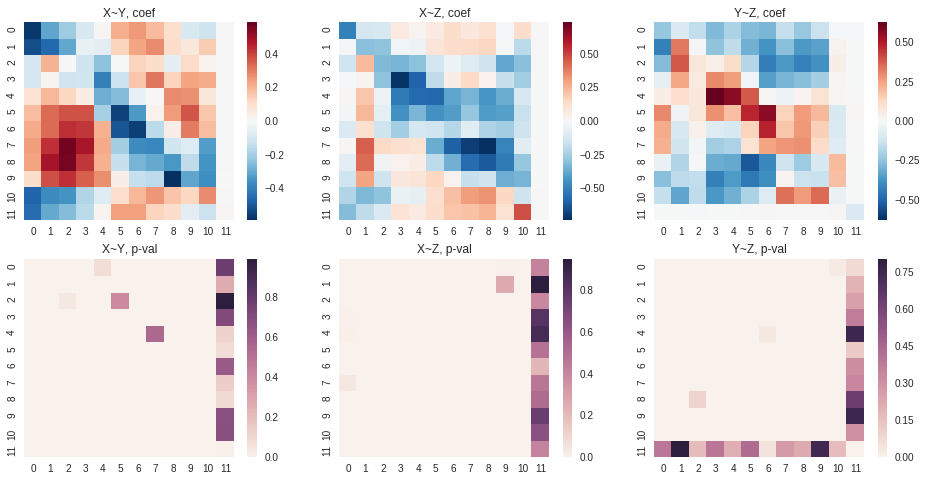

In [28]:
def plot_heatmap(df_x, df_y, df_z, fun):
    def compute(df1, df2):
        cors = np.zeros((12,12))
        pvals = np.zeros((12,12))
        for i in range(1,13):
            for j in range(1,13):
                val = stats.pearsonr(df1.loc[df1.pos_tcr == i, "value"], df2.loc[df2.pos_tcr == j, "value"])
                cors[i-1,j-1] = val[0]
                pvals[i-1,j-1] = val[1]
        return cors, pvals
    
    fig, ax = plt.subplots(2,3, figsize=(16,8))
    
    cors1, pvals1 = compute(df_x, df_y)
    ax[0,0].set_title("X~Y, coef")
    sns.heatmap(cors1, ax=ax[0,0])
    ax[1,0].set_title("X~Y, p-val")
    sns.heatmap(pvals1, ax=ax[1,0])
    
    cors2, pvals2 = compute(df_x, df_z)
    ax[0,1].set_title("X~Z, coef")
    sns.heatmap(cors2, ax=ax[0,1])
    ax[1,1].set_title("X~Z, p-val")
    sns.heatmap(pvals2, ax=ax[1,1])
    
    cors3, pvals3 = compute(df_y, df_z)
    ax[0,2].set_title("Y~Z, coef")
    sns.heatmap(cors3, ax=ax[0,2])
    ax[1,2].set_title("Y~Z, p-val")
    sns.heatmap(pvals3, ax=ax[1,2])
    
    return ((cors1, pvals1), (cors2, pvals2), (cors3, pvals3))

    
(p_c1, p_p1), (p_c2, p_p2), (p_c3, p_p3) = plot_heatmap(df_put_x, df_put_y, df_put_z, stats.pearsonr)

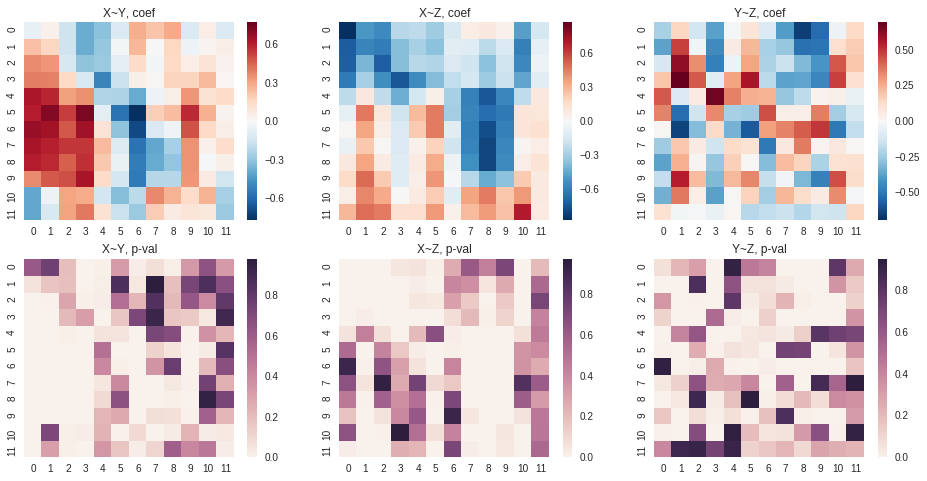

In [29]:
(c_c1, c_p1), (c_c2, c_p2), (c_c3, c_p3) = plot_heatmap(df_cdr_x, df_cdr_y, df_cdr_z, stats.pearsonr)

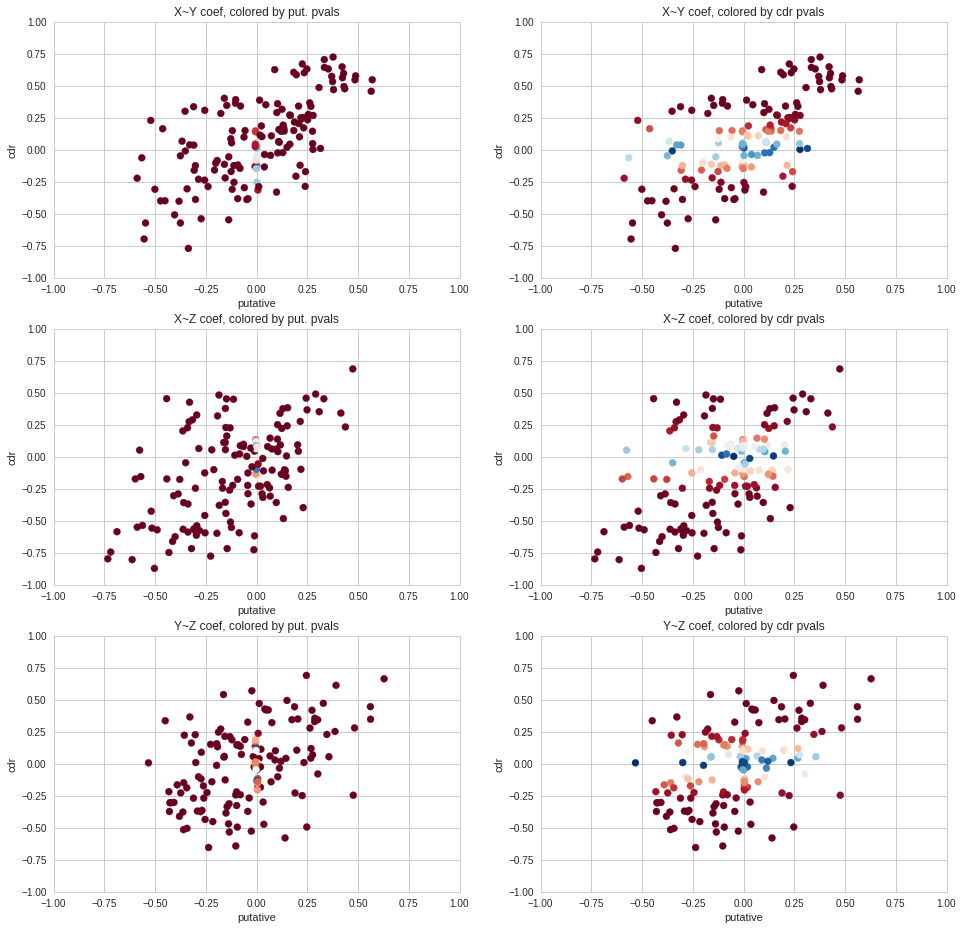

In [30]:
fig, ax = plt.subplots(3, 2, figsize=(16,16))


ax[0,0].set_xlabel('putative')
ax[0,0].set_ylabel('cdr')
ax[0,0].set_xlim([-1,1])
ax[0,0].set_ylim([-1,1])
ax[0,0].scatter(p_c1, c_c1, c = p_p1, cmap="RdBu")
ax[0,0].set_title("X~Y coef, colored by put. pvals")

ax[0,1].set_xlabel('putative')
ax[0,1].set_ylabel('cdr')
ax[0,1].set_xlim([-1,1])
ax[0,1].set_ylim([-1,1])
ax[0,1].scatter(p_c1, c_c1, c = c_p1, cmap="RdBu")
ax[0,1].set_title("X~Y coef, colored by cdr pvals")

ax[1,0].set_xlabel('putative')
ax[1,0].set_ylabel('cdr')
ax[1,0].set_xlim([-1,1])
ax[1,0].set_ylim([-1,1])
ax[1,0].scatter(p_c2, c_c2, c = p_p2, cmap="RdBu")
ax[1,0].set_title("X~Z coef, colored by put. pvals")

ax[1,1].set_xlabel('putative')
ax[1,1].set_ylabel('cdr')
ax[1,1].set_xlim([-1,1])
ax[1,1].set_ylim([-1,1])
ax[1,1].scatter(p_c2, c_c2, c = c_p2, cmap="RdBu")
ax[1,1].set_title("X~Z coef, colored by cdr pvals")

ax[2,0].set_xlabel('putative')
ax[2,0].set_ylabel('cdr')
ax[2,0].set_xlim([-1,1])
ax[2,0].set_ylim([-1,1])
ax[2,0].scatter(p_c3, c_c3, c = p_p3, cmap="RdBu")
ax[2,0].set_title("Y~Z coef, colored by put. pvals")

ax[2,1].set_xlabel('putative')
ax[2,1].set_ylabel('cdr')
ax[2,1].set_xlim([-1,1])
ax[2,1].set_ylim([-1,1])
ax[2,1].scatter(p_c3, c_c3, c = c_p3, cmap="RdBu")
ax[2,1].set_title("Y~Z coef, colored by cdr pvals")

## Summary

Many non-zero and strong correlations gives us a hope for building a model for prediction of coordinates based on two other coordinates.

Correlations are very similar for both datasets, however, more careful analysis of outliers is needed in order to make robust training test.

Strong correlations may exist due to the huge imbalance in the data, i.e., imbalance in the "upside" / "downside" peptide counts.

# Distribution of distances to the nearest putative CDR from real CDRs (by MSE)

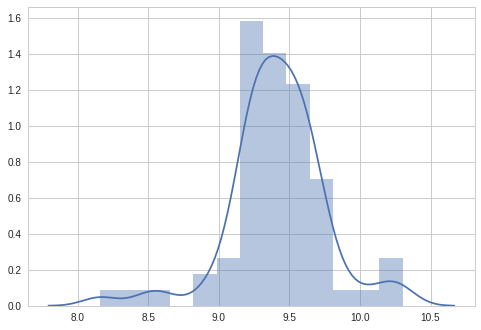

In [31]:
arr_put_coord = np.array(df_put_coord[range(1,13)])
arr_cdr_coord = np.array(df_cdr_coord[range(1,13)])

dist = []
for arr in arr_cdr_coord:
    dist.append(np.sqrt(((arr_put_coord - arr) ** 2).mean(1).min()))
    
sns.distplot(dist)